Lotto draw data:
   WinningNumber1  WinningNumber2  WinningNumber3  WinningNumber4  \
0              18              22               5              25   
1              24              36              13              19   
2              34               5              28              17   
3              12               6              36              13   
4              22              33              21               4   

   WinningNumber5  WinningNumber6    DrawDate  
0              37              31  2025-02-13  
1               9              17  2025-02-11  
2              41              42  2025-02-08  
3              28              37  2025-02-06  
4              29              19  2025-02-04  


C:\Users\My PC\AppData\Local\Temp\ipykernel_7968\3426760624.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['DrawDate'] = df['DrawDate'].map(pd.Timestamp.toordinal)


Mean Squared Error for each winning number:  [190.65 148.02 172.9  165.57 225.6  139.26]
R2 Score for each winning number:  [-0.31 -0.13 -0.25 -0.14 -0.31 -0.23]


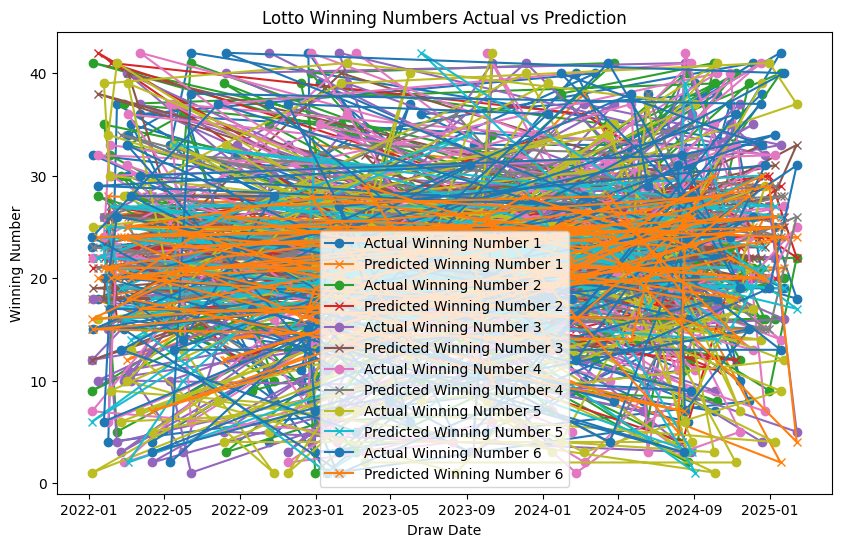

Predicted winning numbers for 2025-02-16: [26, 17, 12, 18, 22, 24]
Predicted winning numbers for 2025-02-18: [32, 17, 26, 22, 2, 24]
Predicted winning numbers for 2025-02-20: [16, 22, 17, 15, 24, 26]
Predicted winning numbers for 2025-02-22: [26, 22, 25, 24, 5, 17]
Predicted winning numbers for 2025-02-24: [29, 26, 24, 30, 17, 22]


In [5]:
# Lotto Number Prediction using historical data with RandomForestRegressor and GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
# Assuming we have historical lotto data
df = pd.read_csv('lotto_final.csv')
# Convert dataset into DataFrame
#df = pd.DataFrame(data)

# Clip the winning numbers to be within the range 1 to 42
df[['WinningNumber1', 'WinningNumber2', 'WinningNumber3', 'WinningNumber4', 'WinningNumber5', 'WinningNumber6']] = df[['WinningNumber1', 'WinningNumber2', 'WinningNumber3', 'WinningNumber4', 'WinningNumber5', 'WinningNumber6']].clip(upper=42)

# Ensure the numbers are unique for each row
def make_unique(row):
    unique_numbers = list(set(row))
    while len(unique_numbers) < 6:
        unique_numbers.append(np.random.randint(1, 43))
    np.random.shuffle(unique_numbers)
    return [int(num) for num in unique_numbers]

df[['WinningNumber1', 'WinningNumber2', 'WinningNumber3', 'WinningNumber4', 'WinningNumber5', 'WinningNumber6']] = df[['WinningNumber1', 'WinningNumber2', 'WinningNumber3', 'WinningNumber4', 'WinningNumber5', 'WinningNumber6']].apply(make_unique, axis=1, result_type='expand')

print("Lotto draw data:")
print(df.head())

# Use the winning numbers as the target variables
X = df[['DrawDate']]
y = df[['WinningNumber1', 'WinningNumber2', 'WinningNumber3', 'WinningNumber4', 'WinningNumber5', 'WinningNumber6']]

# Convert DrawDate column to datetime
df['DrawDate'] = pd.to_datetime(df['DrawDate'])

# Convert dates to ordinal for model training
X['DrawDate'] = df['DrawDate'].map(pd.Timestamp.toordinal)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions using the testing set
y_pred = best_model.predict(X_test)

# Clip the predicted numbers to be within the range 1 to 42
y_pred = np.clip(y_pred, 1, 42)

# Round the predicted numbers and convert to integers
y_pred = np.round(y_pred).astype(int)

# Ensure the predicted numbers are unique for each row
y_pred = np.apply_along_axis(make_unique, 1, y_pred)

# Calculate the mean squared error and r2 score for each winning number
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Round the mse and r2 values to 2 decimal places
mse = np.round(mse, 2)
r2 = np.round(r2, 2)

print("Mean Squared Error for each winning number: ", mse)
print("R2 Score for each winning number: ", r2)

# Convert ordinal dates back to datetime for plotting
X_test['DrawDate'] = X_test['DrawDate'].map(pd.Timestamp.fromordinal)

# Plot the actual numbers and predicted numbers
plt.figure(figsize=(10, 6))
for i in range(1, 7):
    plt.plot(X_test['DrawDate'], y_test.iloc[:, i-1], label=f'Actual Winning Number {i}', marker='o')
    plt.plot(X_test['DrawDate'], y_pred[:, i-1], label=f'Predicted Winning Number {i}', marker='x')
plt.xlabel('Draw Date')
plt.ylabel('Winning Number')
plt.title('Lotto Winning Numbers Actual vs Prediction')
plt.legend()

plt.show()

# Predict future dates
last_date = df['DrawDate'].max()
future_dates = []
for i in range(1, 6):
    if i == 1:
        last_date += pd.Timedelta(days=3)
    else:
        last_date += pd.Timedelta(days=2)
    future_dates.append(last_date)

future_dates_df = pd.DataFrame({'DrawDate': future_dates})
future_dates_df['DrawDate'] = future_dates_df['DrawDate'].map(pd.Timestamp.toordinal)

# Make predictions for future dates
predicted_numbers_list = []
for date in future_dates_df['DrawDate']:
    future_date = pd.DataFrame({'DrawDate': [date]})
    predicted_numbers = best_model.predict(future_date)
    predicted_numbers = np.clip(predicted_numbers, 1, 42)
    predicted_numbers = np.round(predicted_numbers).astype(int)
    predicted_numbers = make_unique(predicted_numbers[0])
    predicted_numbers_list.append(predicted_numbers)

# Convert ordinal dates back to datetime for display
future_dates_df['DrawDate'] = future_dates_df['DrawDate'].map(pd.Timestamp.fromordinal)

for date, numbers in zip(future_dates_df['DrawDate'], predicted_numbers_list):
    print(f"Predicted winning numbers for {date.date()}: {numbers}")
